# Evolution of the Smallest Galaxies in the Universe

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
%matplotlib inline

The Milky Way swarms with orbiting satellite dwarf galaxies of astounding diversity. Some galaxies continue to form stars while others stop and dim in brightness. In computer simulations, the evolutionary history of each dwarf galaxy that leads to these differences is known. Galaxies can lose gas and stop forming stars due to early exposure to stellar radiation (reionization), interaction with the hot gas of the host (ram-pressure stripping), or gravitational interactions with the host/dwarf galaxies (tidal effects).

We propose to use the characteristics of simulated dwarf galaxies from a suite of 20 Milky Way-like galaxies, each of which hosts ~100 dwarf galaxies, to train a supervised machine learning algorithm. The goal is to use only those dwarf galaxy characteristics observable in the present day as features to predict key aspects of their evolutionary history, such as the dominant mechanism by which they lose gas (classification), and/or the timescale of gas loss (regression). We will then apply the simulation-trained algorithm to the characteristics of our own Milky Way’s dwarf galaxy population, which have uncertain evolutionary histories. Identifying the likely histories of dwarf galaxies will help us to understand how galaxies form and evolve over time.


Question: Can simulations of populations of dwarf galaxies around Milky Way-like galaxies be used to reliably predict the evolutionary histories of the observed dwarf galaxies around the Milky Way?

We'll work with two types of data: simulations and observations. The observations come from a wide variety of sources in the literature. Our next task will be to get the data from the simulations. First stage will be to familiarize with the observational data. 

# Observational Data

This compilation of the observed characteristics of dwarf galaxies in the Local Group. The original basis of the list is from McConnachie 2012 (https://arxiv.org/abs/1204.1562) and expanded with data from a variety of sources (e.g. https://arxiv.org/pdf/1901.05465.pdf) from the literature. The list is created in the following notebook: (https://github.com/janagrc/HIdwarflimits/blob/master/HI_Limits.ipynb)

In [2]:
dwarfs = pd.read_csv('./dwarfs.csv',header=(0), comment='#')
dwarfs = dwarfs.drop(['Unnamed: 0'], axis=1)

In [3]:
dwarfs['dist_pc']

0                NaN
1                NaN
2       26302.679919
3       25234.807725
4       23988.329190
           ...      
138     27542.287033
139     36140.986264
140     27797.132678
141    117489.755494
142    107646.521363
Name: dist_pc, Length: 143, dtype: float64

In [4]:
list(dwarfs.columns)

['GalaxyName',
 'RA_hr',
 'RA_min',
 'RA_sec',
 'Dec_deg',
 'Dec_arcmin',
 'Dec_arcsec',
 'EB-V',
 'm-M',
 'm-M_err_pos',
 'm-M_err_neg',
 'vh(km/s)',
 'Vmag',
 'Vmag_err_pos',
 'Vmag_err_neg',
 'PA',
 'e=1-b/a',
 'muVo',
 "rh(')",
 'rh_err_pos',
 'rh_err_neg',
 'vsig_s',
 'vsig_err_pos',
 'vsig_err_neg',
 'vrot_s',
 'vrot_s_err_pos',
 'vrot_s_err_neg',
 'MHI',
 'Data',
 'Key',
 'vsig_g',
 'vsig_g_err_pos',
 'vsig_g_err_neg',
 'vrot_g',
 'note',
 'M-m',
 'Notes',
 'ra',
 'dec',
 'M_V',
 'dist_kpc',
 'M_dyn',
 'M_*',
 'vh_(km/s)_err',
 'vsig_s_upper_limit',
 'vsig_s_err',
 'vh(km/s)_err',
 'orb_pericenter',
 'orb_apocenter',
 'orb_eccentricity',
 'orb_period',
 'orb_period_type',
 'orb_pericenter_0.8',
 'orb_apocenter_0.8',
 'orb_eccentricity_0.8',
 'tau_50',
 'tau_90',
 'dist_pc',
 'dist_mpc',
 'Radius',
 'gal_interference_min',
 'gal_interference_max',
 'Galactic Interference Range',
 'MHI_computed',
 'MHI_source',
 'MHI_type',
 '1sigma',
 'rh_subtable',
 'MHI_method',
 'npix',
 'GUU'

In [5]:
#Rename columns to be more descriptive
cols = ['min_dist_mw_or_m31','orb_pericenter','orb_apocenter','orb_eccentricity','orb_period','Radius','M_V','ell_surf_dist','M_dyn','vsig_s','vrot_s','vsig_g','vrot_g','muVo','tau_90','[Fe/H]','V_GSR','V_LGSR','MHI_computed']

d ={'l':'l (longitude)',
    'b':'b (latitude)',
    'dist_pc': 'Distance',
    'min_dist_mw_or_m31': 'Dist MW or M31, nearest',
    'orb_pericenter': 'Orbit Pericenter',
    'orb_apocenter': 'Orbit Apocenter',
    'orb_eccentricity':'Orbit Eccentricity',
    'orb_period': 'Orbit Period',
    'rh(\')': 'Angular Radius',
    'Radius':'Radius [pc]', # check those
    'M_V': 'V band Magnitude M$_{V}$',
    'ell_surf_dist': 'Distance to LG surf',
    'M_dyn': 'Estimated Dynamical Mass',
    'vsig_s': 'Stellar Velocity Dispersion $\sigma_{star}$', # distribution of velocities of stars in the dwarf
    'vrot_s': 'Stellar Rotation Velocity $V_{rot,star}$', # distribution of velocities of gas in the dwarf
    'vsig_g': 'HI Velocity Dispersion $\sigma_{gas}$',
    'vrot_g': 'HI Rotation Velocity $V_{rot,gas}$',
    'muVo': 'Surface Brightness $\mu_{V}$',
    'vh(km/s)':'Heliocentric Velocity $v_{helio}$',
    'tau_90':"Star Formation Timescale $\\tau_{90}$", # 90% of current stellar formed
    '[Fe/H]':'Mean Metallicity $\\langle $[Fe/H]$\\rangle $', # related to time scale
    'V_GSR':'Galactocentric Velocity $V_{GSR}$', # relative to Milky Way
    'V_LSR':'Local Std of Rest Velocity $V_{LSR}$',
    'V_LGSR':'Local Group Std of Rest Velocity $V_{LGSR}$',
    'MHI_computed':'HI Mass $M_{HI}$ (Detected or Limit)', # emission line of 21cm hydrogen
    'MHI_type': 'MHI_type', # limit or detection
    'X':'3D Position (X)',
    'Y':'3D Position (Y)',
    'Z':'3D Position (Z)' # astropy
   }
# dwarfs = dwarfs.rename(columns=d)

In [6]:
# check radi

dists = dwarfs['dist_pc']
ang_radi = dwarfs['rh(\')']
radi = [dist*ang_rad*2*math.pi/(60*360) for (dist, ang_rad) in zip(dists, ang_radi)]
ang_radi[-4:]

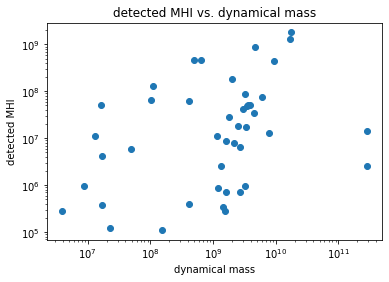

In [83]:
indices = dwarfs['MHI_type']=='detected_mass'

plt.title('detected MHI vs. dynamical mass')
plt.xlabel('dynamical mass (M_sun)')
plt.ylabel('detected MHI (M_sun)')
plt.scatter(dwarfs['M_dyn'][indices], dwarfs['MHI_computed'][indices])
plt.xscale('log')
plt.yscale('log')
plt.show()

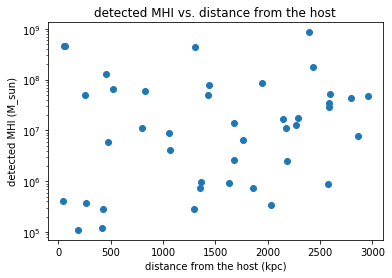

In [86]:
indices = dwarfs['MHI_type']=='detected_mass'

plt.title('detected MHI vs. distance from the host')
plt.xlabel('distance from the host (kpc)')
plt.ylabel('detected MHI (M_sun)')
plt.scatter(dwarfs['min_dist_mw_or_m31'][indices], dwarfs['MHI_computed'][indices])
plt.yscale('log')
plt.show()

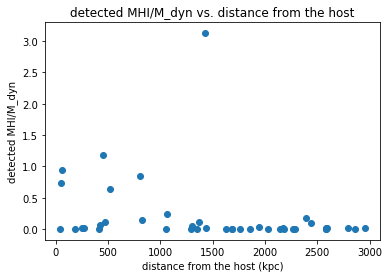

In [89]:
indices = dwarfs['MHI_type']=='detected_mass'

fraction = dwarfs['MHI_computed']/dwarfs['M_dyn']
plt.title('detected MHI/M_dyn vs. distance from the host')
plt.xlabel('distance from the host (kpc)')
plt.ylabel('detected MHI/M_dyn')
plt.scatter(dwarfs['min_dist_mw_or_m31'][indices], fraction[indices])
plt.show()

In [17]:
def plot_scatter(x, y):
    plt.title(y+' vs. '+x)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.scatter(dwarfs[x], dwarfs[y])
    plt.show()